In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import io

Mounted at /content/gdrive


In [ ]:
BASE_DIR = '/content/gdrive/My Drive/flickr8k_new'
WORKING_DIR = '/content/gdrive/My Drive/working'

In [ ]:

vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
print(vgg_model.summary())

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
features='features.pkl'

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
clean(mapping)

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
from tensorflow import keras
caption_model = keras.models.load_model('/content/gdrive/MyDrive/working/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    
    captions = mapping[key]
    
    y_pred = predict_caption(caption_model,features[key],tokenizer,max_length) 
    
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
    

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.530006
BLEU-2: 0.305475


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
def feature_gen_rand(image_path):
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = vgg_model.predict(image, verbose=0)
  return feature


In [ ]:
from PIL import Image
#max_length = 35
#tokenizer = Tokenizer()
import matplotlib.pyplot as plt
def generate_caption_rand(img_path):
    image = Image.open(img_path)
    features = feature_gen_rand(img_path)
    y_pred = predict_caption(caption_model, features, tokenizer, 35)
    # print(features)
    # print('--------------------Predicted--------------------')
    # print(y_pred)
    plt.imshow(image)
    text = y_pred
    b=text
    words = text.split()
    data1="startseq"
    data2="endseq"
    status = False

    for word in words:
        if ((word == data1)or(word==data2)):
            words.remove(word)
            status = True
    if status:
      text = ' '.join(words)
      a=text
      return a
    # plt.imshow(image)
    # return y_pred

man in pink shirt and pink hat is standing in front of red wall


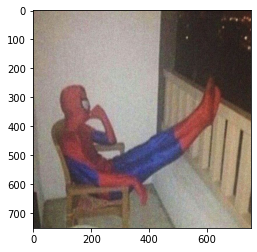

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test.jpg")
print(a)

black dog is walking on the grass with its legs in the air


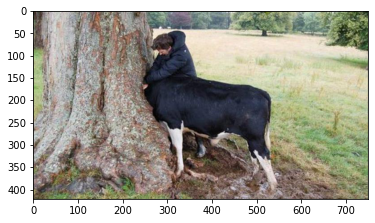

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test2.jpg")
print(a)

man in darkened room playing in the snow


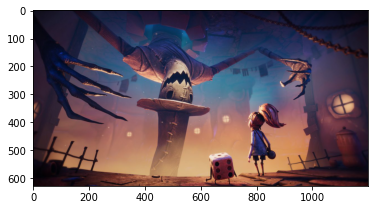

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test1.jpg")
print(a)

two girls are playing in the sand


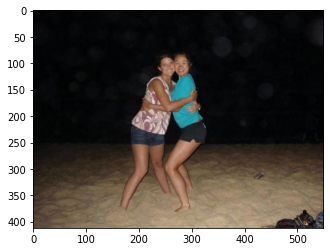

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/test6.jpg")
print(a)

woman wearing blue shirt is reading on the candles


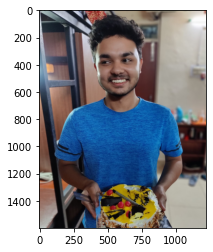

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/kinshuk.jpg")
print(a)

woman in black shirt and pink shorts is sitting on bench outside


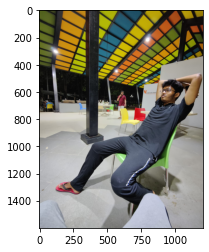

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/sathe.jpg")
print(a)

woman in black shirt and nose blocking the suns colored lips


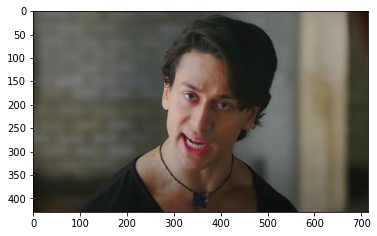

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/actor.jpg")
print(a)

two women sit on bench


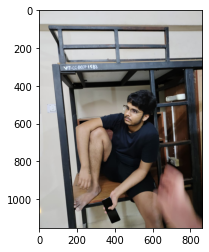

In [ ]:
a=generate_caption_rand("/content/gdrive/MyDrive/flickr8k_new/Images/yashwant.jpeg")
print(a)
